In [1]:
# Source https://github.com/ml-postech/GM-VAE

# Intro

In [2]:
import torch
from torch import nn
from math import log
from torch.nn import functional as F
import torchvision.transforms as T
import numpy as np

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda')

In [5]:
device

device(type='cuda')

In [6]:
# create false image
image = torch.randint(0, 255, (3, 3, 512, 512), dtype=torch.float32).to(device)

# Encoder

In [7]:
# not from gm-vae, just want to uinderstand it better since every task has different encoder and decoder layers
class Encoder(nn.Module):
    def __init__(self, kernel:int=3, stride:int=1, padding:int=0, device='cpu') -> None:
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel, stride, padding), # input image will be bx3x512x512, output bx32x508x508
            nn.AvgPool2d(3, 2), # 2x2 avg pooling, TODO: decide if want to use max pooling output bx32x253x253
            nn.ReLU(), # output bx32x253x253
            nn.Conv2d(32, 64, kernel, stride, padding), # input bx32x253x253, output bx64x251x251
            nn.AvgPool2d(3, 2), # 2x2 avg pooling, output bx64x125x125
            nn.ReLU(), # output bx64x125x125
            nn.Conv2d(64, 64, kernel, stride, padding), # input bx64x125x125, output bx64x123x123
            nn.AvgPool2d(3, 2), # 2x2 avg pooling, output bx64x61x61
            nn.ReLU(), # output bx64x61x61
            nn.Flatten(), # output bx64*61*61
        ).to(device)

        self.encoder.apply(self.init_weights)

        self.layer_mean = nn.Linear(64*61*61, 2048).to(device)
        self.layer_logvar = nn.Linear(64*61*61, 2048).to(device)


        """
        Calculating the output size of the encoder
        [(W-F+2P)/S + 1]. [(512-3+0)/1 + 1] = 510 conv1
        [(W-F)/S] + 1]. [(510-3)/2 + 1] = 254 pool1
        [(W-F+2P)/S + 1]. [(253-3+)/1 + 1] = 252 conv2
        [(W-F)/S] + 1]. [(251-3)/2 + 1] = 125 pool2
        [(W-F+2P)/S + 1]. [(125-3+)/1 + 1] = 123 conv3
        [(W-F)/S] + 1]. [(123-3)/2 + 1] = 61 pool3
        """
    def init_weights(self, m):
      if isinstance(m, nn.Linear):
          nn.init.xavier_uniform(m.weight)
          m.bias.data.fill_(0.01)

    def resize(self, x: torch.Tensor) -> torch.Tensor:
        # resize image to 3x512x512
        x = F.interpolate(x, size=(512, 512), mode='bilinear', align_corners=True)
        return x

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        x = self.resize(x)
        x = self.encoder(x)
        mean = self.layer_mean(x)
        logvar = self.layer_logvar(x)

        return x, mean, logvar

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.encode(x)




In [8]:
# encoder = Encoder()

In [9]:
# import numpy as np
# np.argmax(image)

In [10]:
# image.shape

In [11]:
# image[0][:, 0, 0]

In [12]:
# output_image = encoder.encode(image)
# [(W-F+2P)/S + 1]. [(512-3+0)/1 + 1] = 510 conv1
# [(W-F)/S] + 1]. [(510-3)/2 + 1] = 254 pool1
# [(W-F+2P)/S + 1]. [(253-3+)/1 + 1] = 252 conv2
# [(W-F)/S] + 1]. [(251-3)/2 + 1] = 125 pool2
# [(W-F+2P)/S + 1]. [(125-3+0)/1 + 1] = 123 conv3
# [(W-F)/S] + 1]. [(123-3)/2 + 1] = 61 pool3
# [(W-F+2P)/S + 1]. [(61-3+0)/1 + 1] = 59 conv4
# [(W-F)/S] + 1]. [(59-3)/2 + 1] = 29 pool4


In [13]:
# encoder

# Start of autoencoder class

In [14]:
class VAE(nn.Module):
    def __init__(self, device='cpu') -> None:
        super(VAE, self).__init__()
        self.encoder = Encoder().to(device)
        self.decoder = None

    def reparameterize(self, mean: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        # log var = (log var^2) / 2
        # e ^ log var = e^(log var^2 / 2)
        # e ^ log var = e^ (2 * (log var) / 2)
        # e ^ log var = e^ (log var)
        # e ^ log var = var
        # var = var (this is why we use logvar instead of variation, it makes it possible for back propagation to know if a number is negative or positive)

        eps = 0.5
        z = mean + eps * torch.exp(logvar)
        return z

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z), mean, logvar

In [15]:
# vae = VAE(device).to(device)

In [16]:
# x, mean, logvar = vae.encoder.encode(image)

In [17]:
# x

In [18]:
# print(f"x shape: {x.shape}, mean shape: {mean.shape}, logvar shape: {logvar.shape}")
# print(f"type of x: {type(x)}, type of mean: {type(mean)}, type of logvar: {type(logvar)}")

In [19]:
# z = vae.reparameterize(mean, logvar)

In [20]:
# print(f"z shape: {z.shape}")

In [21]:
# z

# Decoder

In [22]:
class Decoder(nn.Module):
    def __init__(self, kernel:int=3, stride:int=1, padding:int=0, device='cpu') -> None:
        super(Decoder, self).__init__()
        self.kernel = kernel
        self.stride = stride
        self.padding = padding
        self.device = device

        self.decoder = nn.Sequential(
            nn.Linear(2048, 64*61*61),
            nn.Unflatten(dim=1, unflattened_size=(64, 61, 61)),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, 2, self.padding),
            nn.ConvTranspose2d(64, 64, self.kernel, self.stride, self.padding),

            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, 2, self.padding),
            nn.ConvTranspose2d(64, 32, self.kernel, self.stride, self.padding),

            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 2, 2, self.padding),
            nn.ConvTranspose2d(32, 32, 5, 1, self.padding),
            nn.ConvTranspose2d(32, 3, self.kernel, self.stride, self.padding),

            nn.Sigmoid()
        ).to(device)


    def decode(self, x: torch.Tensor) -> torch.Tensor:
        x = self.decoder(x)
        return x

    def forward(self, r_samples: torch.Tensor) -> torch.Tensor:
        return self.decode(r_samples)


# VAE completed

In [23]:
class VAE(nn.Module):
    def __init__(self, kernel:int=3, stride:int=1, padding:int=0, device='cpu') -> None:
        super(VAE, self).__init__()
        self.kernel = kernel
        self.stride = stride
        self.padding = padding
        self.device = device

        self.encoder = Encoder().to(self.device)
        self.decoder = Decoder().to(self.device)

    def reparameterize(self, mean: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        # log var = (log var^2) / 2
        # e ^ log var = e^(log var^2 / 2)
        # e ^ log var = e^ (2 * (log var) / 2)
        # e ^ log var = e^ (log var)
        # e ^ log var = var
        # var = var (this is why we use logvar instead of variation, it makes it possible for back propagation to know if a number is negative or positive)

        eps = 0.5
        z = mean + eps * torch.exp(logvar)
        return z

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded, mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        decoded = self.decoder(z)

        return encoded, mean, logvar, decoded

# Training

In [24]:
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [25]:
cifar = torchvision.datasets.CIFAR10("/content/", download=True, train=False)

Files already downloaded and verified


In [26]:
cifar.data

array([[[[158, 112,  49],
         [159, 111,  47],
         [165, 116,  51],
         ...,
         [137,  95,  36],
         [126,  91,  36],
         [116,  85,  33]],

        [[152, 112,  51],
         [151, 110,  40],
         [159, 114,  45],
         ...,
         [136,  95,  31],
         [125,  91,  32],
         [119,  88,  34]],

        [[151, 110,  47],
         [151, 109,  33],
         [158, 111,  36],
         ...,
         [139,  98,  34],
         [130,  95,  34],
         [120,  89,  33]],

        ...,

        [[ 68, 124, 177],
         [ 42, 100, 148],
         [ 31,  88, 137],
         ...,
         [ 38,  97, 146],
         [ 13,  64, 108],
         [ 40,  85, 127]],

        [[ 61, 116, 168],
         [ 49, 102, 148],
         [ 35,  85, 132],
         ...,
         [ 26,  82, 130],
         [ 29,  82, 126],
         [ 20,  64, 107]],

        [[ 54, 107, 160],
         [ 56, 105, 149],
         [ 45,  89, 132],
         ...,
         [ 24,  77, 124],
        

In [27]:
class CifarDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = X
        self.target = y
        self.transform = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        target = self.target[idx]
        image_reshapes = torch.reshape(torch.tensor(image), (3, 32, 32))

        image_reshapes = image_reshapes / 255.
        transformation = T.Resize(size=(512, 512))
        image_reshapes = transformation(image_reshapes)

        if self.transform:
            image_reshapes = self.transform(image_reshapes)

        return image_reshapes, target

In [28]:
X_train, X_test, y_train, y_test = train_test_split(cifar.data, cifar.targets, test_size=0.2, random_state=42)

In [29]:
train_dataset = CifarDataset(X_train, y_train)

In [30]:
test_dataset = CifarDataset(X_test, y_test)

In [31]:
print(torch.tensor(X_train).shape, torch.tensor(y_train).shape)
print(torch.tensor(X_test).shape, torch.tensor(y_test).shape)

torch.Size([8000, 32, 32, 3]) torch.Size([8000])
torch.Size([2000, 32, 32, 3]) torch.Size([2000])


In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [33]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [34]:
vae = VAE(device=device)

In [35]:
optimizer = torch.optim.SGD(vae.parameters(), lr=learning_rate)

In [36]:
loss_fn = F.mse_loss

In [37]:
len(train_dataloader)

125

In [38]:
vae.train()
total_loss = []
for _ in range(epochs):
  epochs_loss = []
  for i, data in enumerate(train_dataloader):
      # Compute prediction and loss
      X, y = data
      X, y = X.to(device), y.to(device)
      encoded, mean, logvar, decoded = vae(X)

      kl = - 0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar), axis=1)
      kl_mean = kl.mean()

      pixelwise = loss_fn(decoded, X, reduction='none')
      pixelwise = pixelwise.sum(axis=1)
      pixelwise_mean = pixelwise.mean()


      loss = pixelwise_mean + kl_mean

      if not i % 10:
        print("pixelwise", pixelwise_mean)
        print("kl", kl_mean)
        print("loss", loss)
        print()

      optimizer.zero_grad()

      # Backpropagation
      loss.backward()
      optimizer.step()

      epochs_loss.append(loss.cpu().detach().numpy())

  epochs_loss = np.array(epochs_loss)

  avg_loss = np.mean(epochs_loss)

  total_loss.append(avg_loss)
  print("Epoch Loss:", avg_loss)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


pixelwise tensor(0.1521, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(2.8659, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(3.0180, device='cuda:0', grad_fn=<AddBackward0>)

pixelwise tensor(0.1431, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(0.2851, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)

pixelwise tensor(0.1546, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(0.1849, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.3395, device='cuda:0', grad_fn=<AddBackward0>)

pixelwise tensor(0.1536, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(0.1509, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.3045, device='cuda:0', grad_fn=<AddBackward0>)

pixelwise tensor(0.1629, device='cuda:0', grad_fn=<MeanBackward0>)
kl tensor(0.1157, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2786, device='cuda:0', grad_fn=<AddBackward0>)

pixelwise tensor(0.1430, device='cuda:0', grad_fn=<Mean

In [39]:
vae.eval()

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (2): AvgPool2d(kernel_size=3, stride=2, padding=0)
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): AvgPool2d(kernel_size=3, stride=2, padding=0)
      (6): ReLU()
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (8): AvgPool2d(kernel_size=3, stride=2, padding=0)
      (9): ReLU()
      (10): Flatten(start_dim=1, end_dim=-1)
    )
    (layer_mean): Linear(in_features=238144, out_features=2048, bias=True)
    (layer_logvar): Linear(in_features=238144, out_features=2048, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2048, out_features=238144, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(64, 61, 61))
      (2): ReLU()
      (3): ConvTranspose2d(64, 64, kernel_size=(

In [54]:
x, y = next(iter(test_dataloader))

In [65]:
test_dataset[0][0].shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 512, 512])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


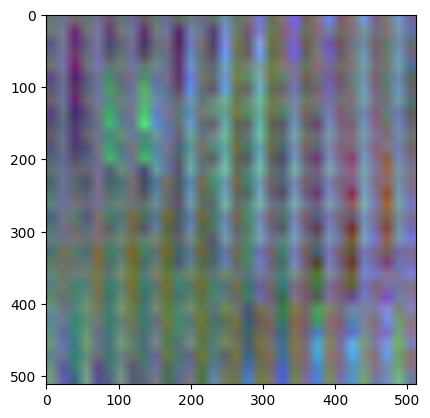

In [67]:
plt.imshow(test_dataset[0][0].T)
plt.show()

In [55]:
image = x[0]
target = y[0]

In [56]:
image.shape

torch.Size([3, 512, 512])

In [57]:
target

tensor(5)

In [58]:
cifar.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [59]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

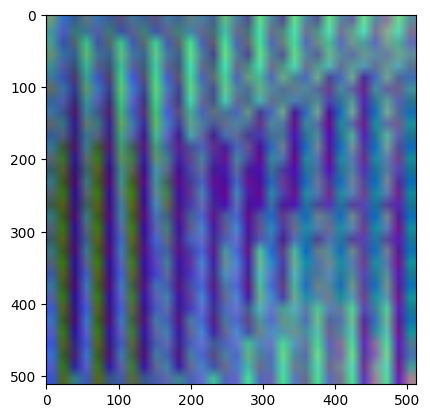

In [60]:
imgplot = plt.imshow(image.T)
plt.show()

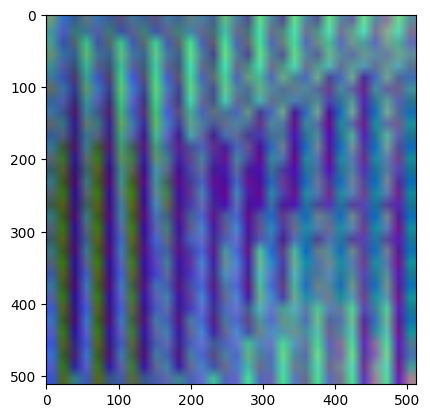

In [61]:
imgplot = plt.imshow(image.T)
plt.show()

In [48]:
image.shape

torch.Size([3, 512, 512])

In [49]:
x[0:2].shape

torch.Size([2, 3, 512, 512])

In [50]:
image_decoded = vae(torch.tensor(x[0:2]).to(device))

<ipython-input-50-4b29dcd48b23>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_decoded = vae(torch.tensor(x[0:2]).to(device))


In [51]:
images = image_decoded[3]

In [52]:
images[0]

tensor([[[0.4812, 0.4819, 0.4800,  ..., 0.4784, 0.4784, 0.4795],
         [0.4790, 0.4816, 0.4804,  ..., 0.4837, 0.4831, 0.4797],
         [0.4843, 0.4907, 0.4861,  ..., 0.4847, 0.4812, 0.4730],
         ...,
         [0.4817, 0.4846, 0.4783,  ..., 0.4904, 0.4857, 0.4749],
         [0.4823, 0.4885, 0.4830,  ..., 0.4909, 0.4887, 0.4782],
         [0.4858, 0.4904, 0.4860,  ..., 0.4892, 0.4840, 0.4772]],

        [[0.4672, 0.4708, 0.4688,  ..., 0.4636, 0.4662, 0.4669],
         [0.4654, 0.4671, 0.4664,  ..., 0.4619, 0.4656, 0.4678],
         [0.4637, 0.4710, 0.4656,  ..., 0.4677, 0.4689, 0.4665],
         ...,
         [0.4587, 0.4601, 0.4575,  ..., 0.4773, 0.4755, 0.4793],
         [0.4613, 0.4619, 0.4608,  ..., 0.4742, 0.4755, 0.4760],
         [0.4660, 0.4675, 0.4699,  ..., 0.4739, 0.4749, 0.4727]],

        [[0.5259, 0.5220, 0.5208,  ..., 0.5258, 0.5247, 0.5260],
         [0.5245, 0.5222, 0.5253,  ..., 0.5282, 0.5283, 0.5273],
         [0.5282, 0.5228, 0.5184,  ..., 0.5228, 0.5127, 0.

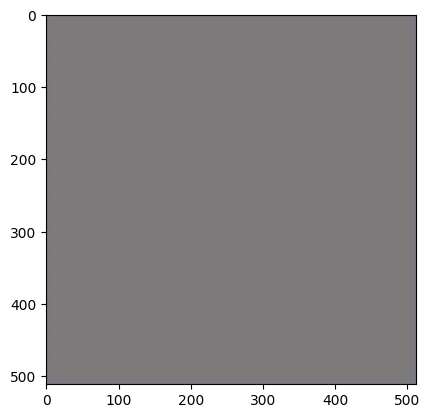

In [53]:
imgplot = plt.imshow(images[0].cpu().detach().numpy().T)
plt.show()